## Libraries

The relevant libraries are imported. These include the numerical computation and plotting libraries.

Warnings that are occasionally generated when codes are ran are suppressed using the _"**ignore**"_ argument

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor
import os

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

%config InlineBackend.figure_format='png'

## Dataset

Data preprocessing enables us to ensure the data completeness and duplication and have a glimpse of the summary of the data statistics.

In [2]:
df= pd.read_excel('H2_CH4_N2_Brine IFT.xlsx').drop(['Reference', 'Title'], axis=1)
df.dropna(inplace=True)
df

,Pressure,Temperature,Salinity,xN2,xCH4,Density difference,IFT
0,1.033929,295.15,0.341880,0,20,1030.60,69.24
1,1.033929,313.15,0.341880,0,20,1024.40,67.85
2,1.033929,333.15,0.341880,0,20,1015.00,65.24
3,1.033929,295.15,0.341880,0,50,1018.40,66.26
4,1.033929,313.15,0.341880,0,50,1013.00,64.88
...,...,...,...,...,...,...,...
1657,6.892857,343.15,3.418803,5,70,1035.81,63.78
1658,10.339286,343.15,3.418803,5,70,1017.88,59.37
1659,13.785714,343.15,3.418803,5,70,1000.30,56.29
1660,17.232143,343.15,3.418803,5,70,983.14,53.12


In [3]:
X= df.drop(['IFT'],axis=1)

In [4]:
y=df['IFT'].astype(float)

In [5]:
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test=train_test_split(X,y, random_state=0,train_size=.7)

## Hyperparameter tuning

### Bayesian Optimization

In [6]:
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

# Pipeline with normalization
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', ExtraTreesRegressor())
])

# Search space
param_grid = {
    'model__max_features': Categorical(['sqrt', 'log2', None]),
    'model__max_depth': Integer(3, 10),
    'model__n_estimators': Integer(10, 150)
}

# Start time
start_time = time.time()

# Bayesian Optimization
bayes_search = BayesSearchCV(
    pipeline,
    param_grid,
    n_iter=50,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Model fitting
bayes_search.fit(X_train, y_train)

# Best parameters and corresponding score
print("Best Parameters: ", bayes_search.best_params_)
print("Best Score: ", bayes_search.best_score_)

# End time
end_time = time.time()

# Elapsed time
elapsed_time = end_time - start_time
print(f"Hyperparameter tuning time: {elapsed_time} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

## Model training

The optimal hyperparameter values are used in training the model.

In [7]:
features = bayes_search.best_params_['model__max_features']
max_depth = bayes_search.best_params_['model__max_depth']
n_estimators = bayes_search.best_params_['model__n_estimators']

In [8]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('extratrees', ExtraTreesRegressor(max_depth=max_depth,
                               n_estimators=n_estimators,
                               max_features=features))])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('extratrees',
                 ExtraTreesRegressor(max_depth=10, max_features=None,
                                     n_estimators=149))])

In [9]:
import joblib
# Model save
joblib.dump(pipeline, 'ET.joblib')

# Load model for predictions
loaded_extratrees_model = joblib.load('ET.joblib')

## Evaluating model performance

Here, various statistical metrics such as mean absolute error, root mean square, and coefficient of determination are used to assess the performance of the constructed model.

In [10]:
# Dependent and independent variables
X_all = np.array(X)
y_all = np.array(y)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Coefficient of determination (R2)
extratrees_trainscore = loaded_extratrees_model.score(X_train, y_train)
extratrees_testscore = loaded_extratrees_model.score(X_test, y_test)
extratrees_allscore = loaded_extratrees_model.score(X_all, y_all)

# Mean absolute error (MAE)
extratrees_mean_abs_train=mean_absolute_error(y_train,loaded_extratrees_model.predict(X_train))
extratrees_mean_abs_test=mean_absolute_error(y_test,loaded_extratrees_model.predict(X_test))
extratrees_mean_abs_all=mean_absolute_error(y_all,loaded_extratrees_model.predict(X_all))


# Root mean square error (RMSE)
extratrees_root_mean_squared_train=(mean_squared_error(y_train,loaded_extratrees_model.predict(X_train)))**0.5
extratrees_root_mean_squared_test=(mean_squared_error(y_test,loaded_extratrees_model.predict(X_test)))**0.5
extratrees_root_mean_squared_all=(mean_squared_error(y_all,loaded_extratrees_model.predict(X_all)))**0.5


# Average absolute percentage relative error
extratrees_aapre_train = np.mean(np.abs((y_train- loaded_extratrees_model.predict(X_train)) / y_train))*100
extratrees_aapre_test = np.mean(np.abs((y_test- loaded_extratrees_model.predict(X_test)) / y_test))*100
extratrees_aapre_all = np.mean(np.abs((y_all- loaded_extratrees_model.predict(X_all)) / y_all))*100

In [12]:
extratrees_summary = {
    'R$^{2}$': [extratrees_trainscore, extratrees_testscore, extratrees_allscore],
    'MAE': [extratrees_mean_abs_train, extratrees_mean_abs_test, extratrees_mean_abs_all],
    'RMSE': [extratrees_root_mean_squared_train, extratrees_root_mean_squared_test, extratrees_root_mean_squared_all],
    'MAPE' : [extratrees_aapre_train, extratrees_aapre_test, extratrees_aapre_all]
}

In [13]:
extratrees_summary = pd.DataFrame(extratrees_summary).T

In [14]:
extratrees_summary = extratrees_summary.rename(columns = {0: 'Train', 1: 'Test', 2: 'All'})

In [15]:
extratrees_summary

,Train,Test,All
R$^{2}$,0.996626,0.983851,0.992787
MAE,0.329877,0.725329,0.448608
RMSE,0.435917,0.954242,0.637466
MAPE,0.509313,1.142545,0.699435


## Model predictions for train, test, and entire dataset

### Train data

In [16]:
df1=pd.DataFrame(X_train)

df2=pd.DataFrame(y_train)

df3=pd.DataFrame(loaded_extratrees_model.predict(X_train), columns=['Predicted (Train)'])

df3.index=df2.index

testpred=pd.concat([df1, df2, df3],axis=1)

testpred.to_excel("ET_Train.xlsx")

### Test data

In [17]:
df1=pd.DataFrame(X_test)

df2=pd.DataFrame(y_test)

df3=pd.DataFrame(loaded_extratrees_model.predict(X_test), columns=['Predicted (Test)'])

df3.index=df2.index

testpred=pd.concat([df1, df2, df3],axis=1)

testpred.to_excel("ET_Test.xlsx")

### All data

In [25]:
df1=pd.DataFrame(X)

df2=pd.DataFrame(y)

df3=pd.DataFrame(loaded_extratrees_model.predict(X), columns=['Predicted (All)'])

df3.index=df2.index

testpred=pd.concat([df1, df2, df3],axis=1)

testpred.to_excel("ET_All.xlsx")

## Permutation importance

Contrary to the correlations matrices, permutation importance considers the non-monotonic effect of the features on the output.

Density difference: 1.0531395602629934
xCH4: 0.20053759486066658
Temperature: 0.1229456342557665
Pressure: 0.07168604244772728
Salinity: 0.013878632250863828
xN2: 0.008022855607693224


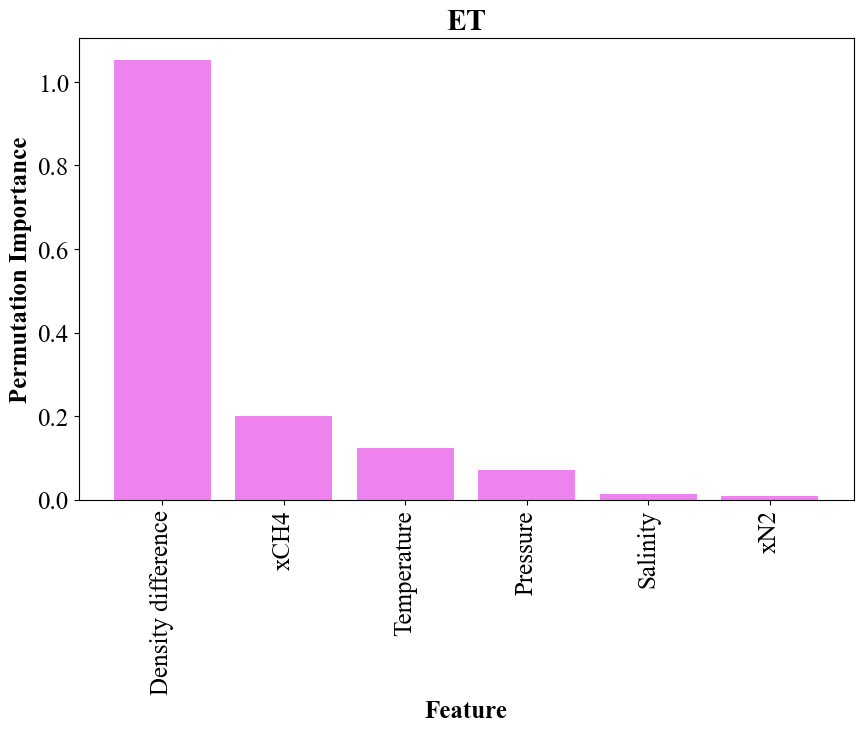

In [19]:
from sklearn.inspection import permutation_importance

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

# Permutation importance
result = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=0, n_jobs=-1)

# Feature importance and scores
feature_importance = result.importances_mean
feature_names = X.columns

# Sorted feature importance
sorted_idx = np.argsort(feature_importance)[::-1]

for i in sorted_idx:
    print(f'{feature_names[i]}: {feature_importance[i]}')

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx], color = 'violet')
plt.xticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx], rotation=90)

plt.xlabel('Feature', fontweight = 'bold')
plt.ylabel('Permutation Importance', fontweight = 'bold')
plt.title('ET', fontweight = 'bold')

plt.savefig('ET_Permutation Importance.png',
            format='png',
            dpi=300,
            bbox_inches='tight')

plt.show()

## Joint plot

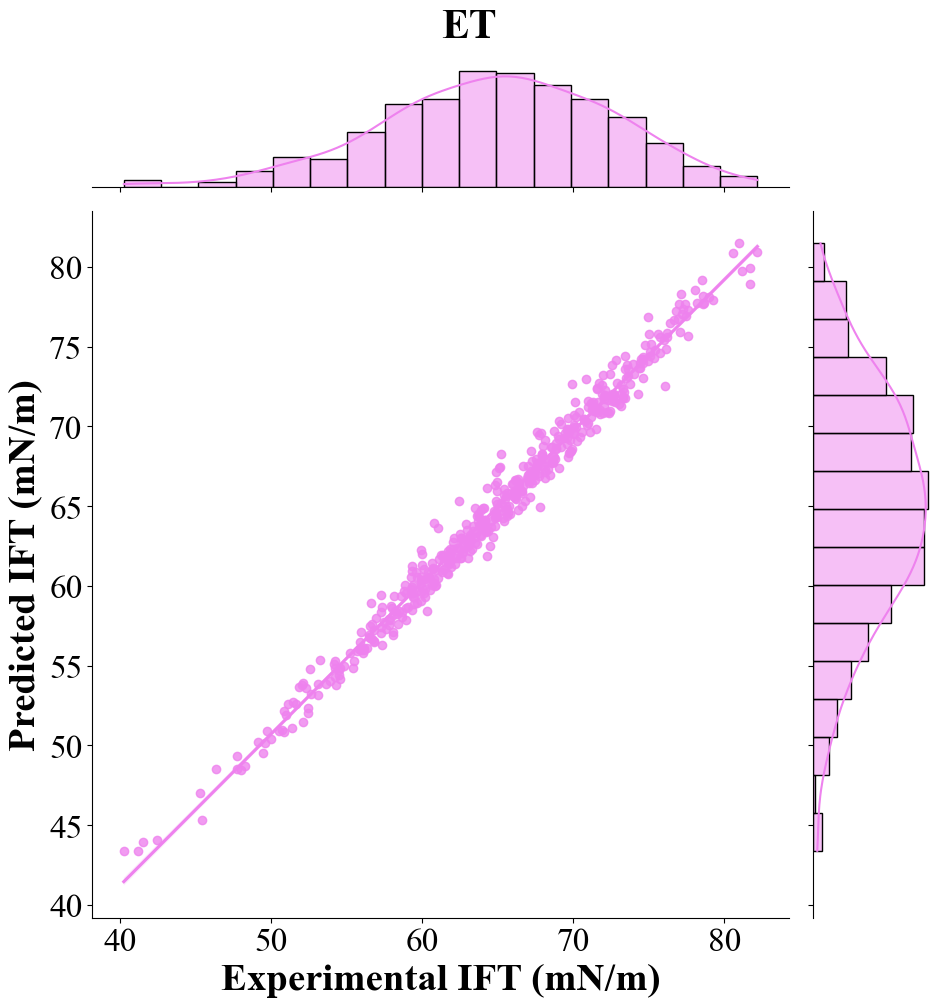

In [21]:
data = pd.read_excel('ET_Test.xlsx')

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24

fig= sns.jointplot(x=data['IFT'],y=data['Predicted (Test)'],data=data,kind='reg', color='violet', height=10)
plt.gca().set()

fig.fig.suptitle("ET", y=1.02, fontsize=30, fontweight='bold')

# Axis labels
fig.set_axis_labels('Experimental IFT (mN/m)', 'Predicted IFT (mN/m)', fontsize=28, fontweight = 'bold')

# Saved plot
fig.savefig("ET_Joint plot of Predicted IFT Vs Experimental IFT.png",
            format='png',
            dpi=300,
            bbox_inches='tight')

plt.show()

## Density kernel plot

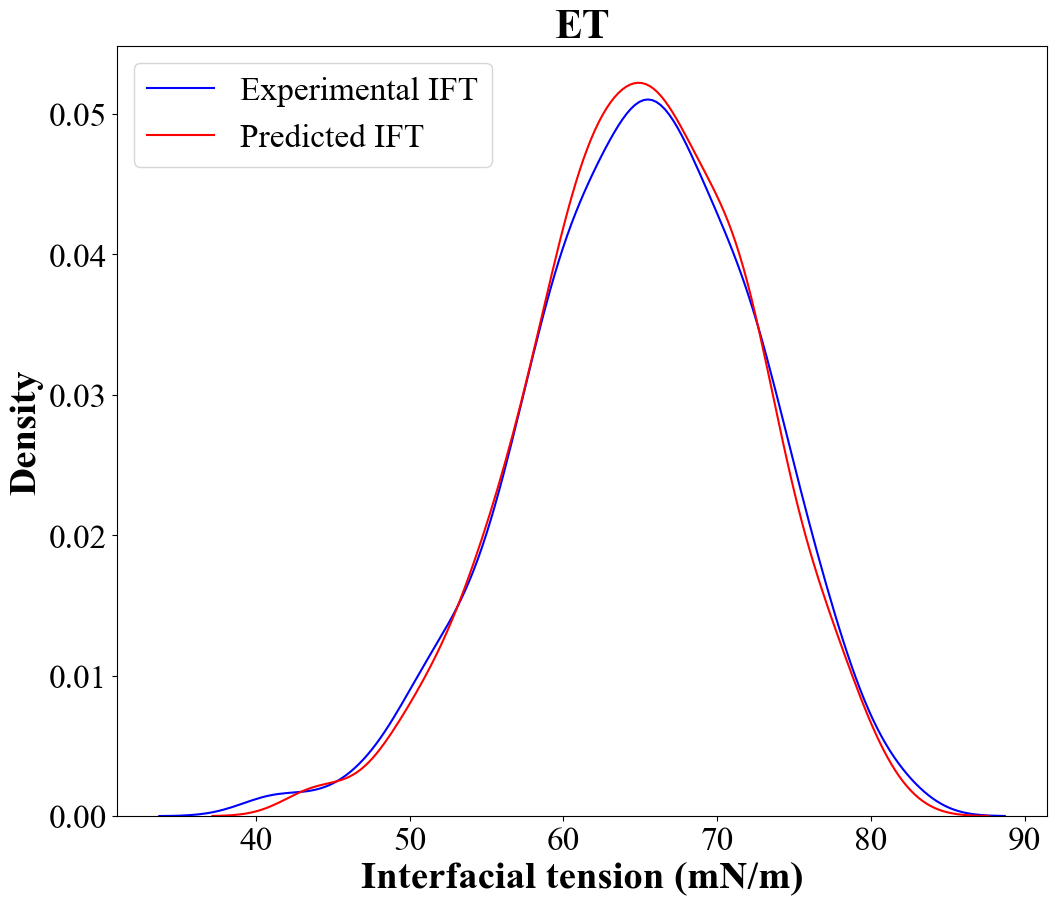

In [22]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24

fig, ax = plt.subplots(figsize=(12, 10))

# Distribution for experimental IFT values
ax1 = sns.distplot(y_test, hist=False, color="b", label="Experimental IFT")

# Distribution for predicted IFT values and previous distribution on the same axis
sns.distplot(loaded_extratrees_model.predict(X_test), hist=False, color="r", label="Predicted IFT", ax=ax1)

# Legend
ax1.legend()

# Chart customization
ax.set_title("ET", fontsize=30, fontweight="bold")
ax.set_xlabel("Interfacial tension (mN/m)", fontsize=28, fontweight="bold")
ax.set_ylabel("Density", fontsize = 28, fontweight="bold")

# Saved plot
plt.savefig("ET_Density_kernel_plot.png",
            format='png',
            dpi=300,
            bbox_inches='tight')

plt.show()